# Convergence Analysis of Adapted Empirical Measure and Discrete Optimal Transport Performance

## Overview
This notebook investigates the convergence properties of the adapted empirical measure and evaluates the performance of discrete optimal transport calculations on larger trees. The study consists of:

1. **Generating and Comparing Two Brownian Motion Adapted Trees**
   - We sample paths from two Brownian motions.
   - Construct adapted trees for each.
   - Compare the values obtained against benchmark values.

2. **Benchmarking**
   - Compute the theoretical adapted Wasserstein distance.
   - Validate results against numerical computations using discrete trees.

This approach helps assess the accuracy and efficiency of the empirical adapted measure in capturing the underlying stochastic process.

In [2]:
import numpy as np
import os
import sys
import warnings
import time

# Define paths to relevant modules
measure_sampling_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling')
trees_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees')
Benchmark_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Benchmark_value_Gausian')
awd_trees_path = os.path.abspath('/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AWD_trees')

# Add paths to sys.path
for path in [measure_sampling_path, trees_path, Benchmark_path, awd_trees_path]:
    if path not in sys.path:
        sys.path.append(path)

# Import necessary modules
from Gen_Path_and_AdaptedTrees import generate_adapted_tree
from Tree_Node import *
from TreeAnalysis import *
from TreeVisualization import *
from Save_Load_trees import *
from Tree_AWD_utilities import *
from Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared
from Gurobi_AOT import *
from Nested_Dist_Algo import compute_nested_distance

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Checking convergence of adapted measure

grid
Time Steps: 6, Method: grid, Run 1/10 for sample size 200...
Time Steps: 6, Method: grid, Run 2/10 for sample size 200...
Time Steps: 6, Method: grid, Run 3/10 for sample size 200...
Time Steps: 6, Method: grid, Run 4/10 for sample size 200...
Time Steps: 6, Method: grid, Run 5/10 for sample size 200...
Time Steps: 6, Method: grid, Run 6/10 for sample size 200...
Time Steps: 6, Method: grid, Run 7/10 for sample size 200...
Time Steps: 6, Method: grid, Run 8/10 for sample size 200...
Time Steps: 6, Method: grid, Run 9/10 for sample size 200...
Time Steps: 6, Method: grid, Run 10/10 for sample size 200...
Time Steps: 6, Method: grid, Run 1/10 for sample size 500...
Time Steps: 6, Method: grid, Run 2/10 for sample size 500...
Time Steps: 6, Method: grid, Run 3/10 for sample size 500...
Time Steps: 6, Method: grid, Run 4/10 for sample size 500...
Time Steps: 6, Method: grid, Run 5/10 for sample size 500...
Time Steps: 6, Method: grid, Run 6/10 for sample size 500...
Time Steps: 6, Met

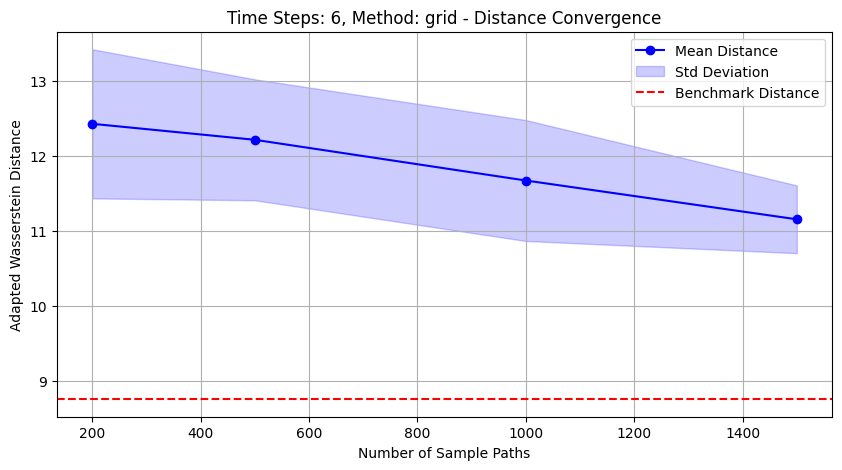

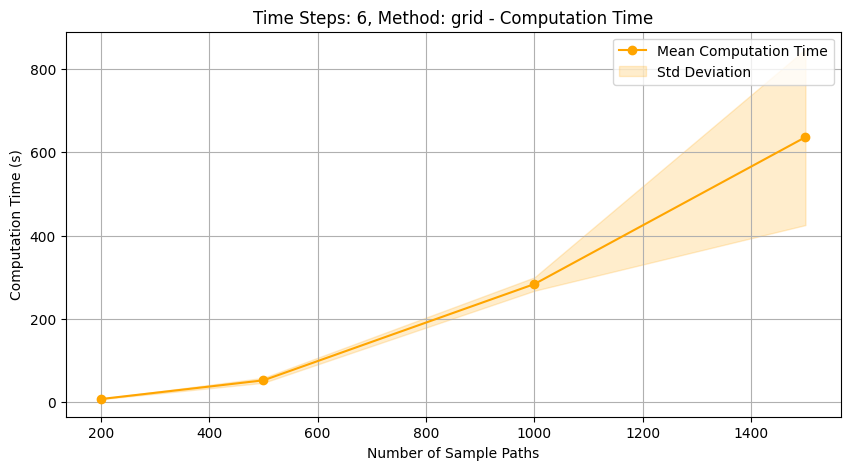

In [3]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define common parameters
scale1 = 1
scale2 = 0.5
init_a, init_b = 1, 2
use_weights = 1
n_runs = 10

# Define the methods and time steps to loop over
methods = ["grid"]#["kmeans", "kmeans_new", "kmeans_grid", "grid"]
time_steps_list = [6]

# Define sample path sizes for each time step
sample_sizes_map = {
    2: [200, 500, 1000, 2000, 4000, 8000],
    3: [200, 500, 1000, 2000, 4000],
    4: [200, 500, 1000, 2000, 3000],
    5: [200, 500, 1000, 2000],
    6: [200, 500, 1000, 1500]
}

# Loop over each time step and method combination
for time_steps in time_steps_list:
    # Select the corresponding sample sizes for the current time step
    sample_sizes = sample_sizes_map[time_steps]
    
    for method in methods:
        print(method)
        # Arrays to store results for the current time_steps and method
        distances_all = np.zeros((len(sample_sizes), n_runs))
        times_all = np.zeros((len(sample_sizes), n_runs))
        
        # Compute the benchmark adapted Wasserstein distance once for this time step
        # Note: using t = time_steps - 1 as in your original code
        t = time_steps - 1
        a_vec, A_mat = build_mean_and_cov(t, mean_val=init_a, var_factor=scale1**2)
        b_vec, B_mat = build_mean_and_cov(t, mean_val=init_b, var_factor=scale2**2)
        distance_squared = adapted_wasserstein_squared(a_vec, A_mat, b_vec, B_mat)
        
        # Loop over each sample size and run n_runs for statistics
        for i, num_paths in enumerate(sample_sizes):
            for run_idx in range(n_runs):
                print(f"Time Steps: {time_steps}, Method: {method}, Run {run_idx+1}/{n_runs} for sample size {num_paths}...")
                
                # Generate the adapted trees for both processes using the current method
                bm1_root, _ = generate_adapted_tree(
                    num_paths=num_paths, 
                    time_steps=time_steps, 
                    x_init=init_a, 
                    scale=scale1, 
                    use_weights=use_weights, 
                    model='brownian', 
                    return_times=True,
                    cluster_method=method
                )
                bm2_root, _ = generate_adapted_tree(
                    num_paths=num_paths, 
                    time_steps=time_steps, 
                    x_init=init_b, 
                    scale=scale2, 
                    use_weights=use_weights, 
                    model='brownian', 
                    return_times=True,
                    cluster_method=method
                )
                
                # Compute the nested (adapted optimal transport) distance and timing
                max_depth = get_depth(bm1_root)
                start_time = time.time()
                distance_pot = compute_nested_distance(
                    bm1_root, bm2_root, max_depth, 
                    method="solver_lp_pot", 
                    return_matrix=False, 
                    lambda_reg=0, 
                    power=2
                )
                elapsed_time_pot = time.time() - start_time
                
                # Adjust distance by subtracting the initial difference in squares (if needed)
                distance_pot -= (init_a - init_b) ** 2
                
                # Store the computed distance and time
                distances_all[i, run_idx] = distance_pot
                times_all[i, run_idx] = elapsed_time_pot
        
        # Compute statistics over runs
        distances_mean = distances_all.mean(axis=1)
        distances_std = distances_all.std(axis=1)
        times_mean = times_all.mean(axis=1)
        times_std = times_all.std(axis=1)
        
        # ---------------------------------------------------------
        # PLOT 1: Distance convergence with mean ± std band
        # ---------------------------------------------------------
        plt.figure(figsize=(10, 5))
        plt.plot(sample_sizes, distances_mean, marker="o", color="blue", label="Mean Distance")
        plt.fill_between(
            sample_sizes, 
            distances_mean - distances_std, 
            distances_mean + distances_std, 
            color="blue", alpha=0.2, label="Std Deviation"
        )
        plt.axhline(y=distance_squared, color="red", linestyle="--", label="Benchmark Distance")
        plt.xlabel("Number of Sample Paths")
        plt.ylabel("Adapted Wasserstein Distance")
        plt.title(f"Time Steps: {time_steps}, Method: {method} - Distance Convergence")
        plt.legend()
        plt.grid()
        plt.show()
        
        # ---------------------------------------------------------
        # PLOT 2: Computation time with mean ± std band
        # ---------------------------------------------------------
        plt.figure(figsize=(10, 5))
        plt.plot(sample_sizes, times_mean, marker="o", color="orange", label="Mean Computation Time")
        plt.fill_between(
            sample_sizes, 
            times_mean - times_std, 
            times_mean + times_std, 
            color="orange", alpha=0.2, label="Std Deviation"
        )
        plt.xlabel("Number of Sample Paths")
        plt.ylabel("Computation Time (s)")
        plt.title(f"Time Steps: {time_steps}, Method: {method} - Computation Time")
        plt.legend()
        plt.grid()
        plt.show()


## Cheching computational time for large sample size

In [7]:
# Set parameters
num_paths = 2000   # Number of sample paths
time_steps = 3   # Number of time steps per path
scale1 = 1
scale2 = 0.5
use_weights = 1

# Generate adapted trees for Brownian motion
print("Generating adapted tree from the first Brownian motion...")
bm1_root, bm1_time_tdetail = generate_adapted_tree(num_paths=num_paths, time_steps=time_steps, scale=scale1, use_weights=use_weights, model='brownian', return_times=True)

print("Generating adapted tree from the second Brownian motion...")
bm2_root, bm2_time_tdetail = generate_adapted_tree(num_paths=num_paths, time_steps=time_steps, scale=scale2, use_weights=use_weights, model='brownian', return_times=True)

print(f"Brownian Motion Adapted Tree 1 generated successfully in {sum(bm1_time_tdetail):.2f} seconds.")
print(f"Time breakdown: Sample generation: {bm1_time_tdetail[0]:.2f}s, Measure k-means: {bm1_time_tdetail[1]:.2f}s, Tree construction: {bm1_time_tdetail[2]:.2f}s")

print(f"Brownian Motion Adapted Tree 2 generated successfully in {sum(bm2_time_tdetail):.2f} seconds.")
print(f"Time breakdown: Sample generation: {bm2_time_tdetail[0]:.2f}s, Measure k-means: {bm2_time_tdetail[1]:.2f}s, Tree construction: {bm2_time_tdetail[2]:.2f}s")

Generating adapted tree from the first Brownian motion...
Generating adapted tree from the second Brownian motion...
Brownian Motion Adapted Tree 1 generated successfully in 4.16 seconds.
Time breakdown: Sample generation: 0.01s, Measure k-means: 4.15s, Tree construction: 0.01s
Brownian Motion Adapted Tree 2 generated successfully in 3.87 seconds.
Time breakdown: Sample generation: 0.01s, Measure k-means: 3.86s, Tree construction: 0.01s


In [8]:
# Benchmarking Adapted Wasserstein Distance

# Define parameters
a, b = 0, 0
var_a, var_b = scale1**2, scale2**2
t = time_steps-1

# Build mean and covariance matrices for both processes
a_vec, A_mat = build_mean_and_cov(t, mean_val=a, var_factor=var_a)
b_vec, B_mat = build_mean_and_cov(t, mean_val=b, var_factor=var_b)

# Compute adapted Wasserstein squared distance
distance_squared = adapted_wasserstein_squared(a_vec, A_mat, b_vec, B_mat)
distance = np.sqrt(distance_squared)

print(f"Adapted Wasserstein Squared Distance: {distance_squared:.4f}")
print(f"Adapted Wasserstein Distance: {distance:.4f}")

Adapted Wasserstein Squared Distance: 0.7500
Adapted Wasserstein Distance: 0.8660


In [9]:
# Compute optimal transport using POT solver
print("\nComputing adapted optimal transport using POT solver...")
max_depth = get_depth(bm1_root)
start_time = time.time()
distance_pot = compute_nested_distance(
    bm1_root, bm2_root, max_depth, method="solver_lp_pot", return_matrix=False, lambda_reg=4, power = 2
)
elapsed_time_pot = time.time() - start_time
print(f"POT Solver Distance: {distance_pot-(a-b)**2:.4f}, Computation Time: {elapsed_time_pot:.2f}s")


Computing adapted optimal transport using POT solver...
POT Solver Distance: 0.7602, Computation Time: 0.63s
